In [30]:
import kwant
import matplotlib.pyplot as plt
%matplotlib notebook
import scipy.sparse.linalg as sla
import numpy as np
import matplotlib.cm as cm

In [31]:
def create_sys(t, delta, mu, W, L, disorder, seed = 14):
    sys = kwant.Builder() #create the system, but it's empty
    a = 1 #distance between the sites (lattice constant)
    lat = kwant.lattice.square(a) #defines the lattice
    for i in range(L):#itteration horizontally over the system (0--L-1)
        for j in range(W): #itteration vertically over the system (0--W-1)
            np.random.seed(seed)#using the same imperfect system multiple times
            mu_i = np.random.randn()*disorder + mu
            if j == 0:
                sys[lat(i, j)] = -mu_i #on-site Hamiltonian ($a_{i,j}^\dag a_{i,j}*mu$) 
            if j == 1:
                sys[lat(i, j)] = mu_i #on-site Hamiltonian ($a_{i,j}^\dag a_{i,j}*-mu$)  
            if i>0:
                sys[(lat(i-1, j), lat(i, j))] = t #horizontal hopping ($a_{i-1,j}^\dag a_{i,j}*t$)
                if j>0:
                    sys[(lat(i-1, j-1), lat(i, j))] = delta # superconducting gap ($a_{i-1,j-1}^\dag a_{i,j}*t$)
                    sys[(lat(i-1, j), lat(i, j-1))] = -delta # superconducting gap ($a_{i-1,j}^\dag a_{i,j-1}*t$)
                    sys[(lat(i-1, j), lat(i, j))] = -t #horizontal hopping ($a_{i-1,j}^\dag a_{i,j}*t$)
    return sys

In [32]:
def disorder_energy(t, delta, mu, W, L, disorder,seed = 15):
    sys = create_sys(t, delta, mu, W, L,disorder,seed)              
    ham_mat = sys.finalized().hamiltonian_submatrix(sparse=True) # i think solves the hamiltonian
    ev = sla.eigsh(ham_mat, k=8, which='SM', return_eigenvectors=False, maxiter=1000000) #which = what energy levels to return
                                                # SM = smallest absolute value, i.e. closest to 0, maxiter = ???, k = 8 
                                                #(number of eigenvalues we compute)
    return ev #returns eigenvalues of system closest to zero
"""
Disorder is is the standard deviation from our mean mu 
"""

'\nDisorder is is the standard deviation from our mean mu \n'

In [33]:
"""
phase_diagram:
    Inputs: t (float), constant value of hopping potential
            deltarange (list), various values of superconducting gap
            murange (list), various values of chemical potential
            W (int) = system width
            L (int) = system length
            disorder (float) = standard deviation of normal distribution where we select mu values
            disorder_realisations = number of different imperfect latticces I test
    Outputs:
            phase diagram for topological phase (in black) with mu on x-axis and and delta on the y-axis
confused by why we should use mu/t and delta/t? how does this cover all the variables space??
"""

'\nphase_diagram:\n    Inputs: t (float), constant value of hopping potential\n            deltarange (list), various values of superconducting gap\n            murange (list), various values of chemical potential\n            W (int) = system width\n            L (int) = system length\n            disorder (float) = standard deviation of normal distribution where we select mu values\n            disorder_realisations = number of different imperfect latticces I test\n    Outputs:\n            phase diagram for topological phase (in black) with mu on x-axis and and delta on the y-axis\nconfused by why we should use mu/t and delta/t? how does this cover all the variables space??\n'

In [34]:
def disorder_phase_diagram(t, deltarange, murange, W, L, disorder, disorder_realisations):
    phase_realisations = [] #1 = topological, 0 = trivial
    MU,DELTA = np.meshgrid(murange,deltarange) #creates 3D grid
    for i in range(disorder_realisations):
        phase_realisations.append([])
        for j,mu in enumerate(murange):
            phase_realisations[i].append([])
            for delta in deltarange:
                if np.amin(np.absolute(disorder_energy(t, delta, mu, W, L, disorder, 5+i))) < 10**-10:
                    phase_realisations[i][j].append(1)
                else:
                    phase_realisations[i][j].append(0)
    phase_probs = np.mean(phase_realisations, axis = 0)
    
    plt.ylabel("Delta")
    plt.xlabel("Mu")
    plt.title("Phase diagram of Kitaev wire", y = 1.04)
    #topological phase is plotted in black
    plt.imshow(phase_probs, extent = (murange.min(), murange.max(), deltarange.min(), deltarange.max()),cmap = cm.gist_yarg) 
    

<IPython.core.display.Javascript object>


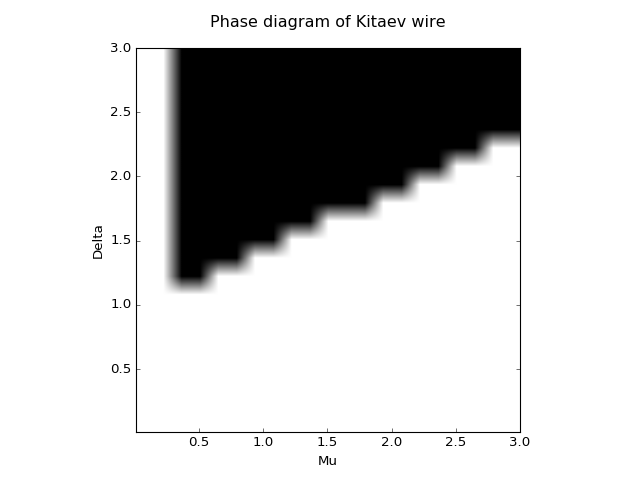

In [42]:
deltarange = np.linspace(0.01, 3.0, 21) #number of inner array elements
murange = np.linspace(0.01, 3.0, 21) #number of inner arrays
#disorder_phase_diagram(t, deltarange, murange, W, L, disorder, disorder_realisations)
disorder_phase_diagram(1., deltarange, murange, 2, 100, 0.0, 1) 

In [36]:
"""
Goal = plot the phase boundary against the disorder (standard deviation) for different values of delta

What is the 'phase boundary'? = when mu is greater than this value we are in the trivial phase, so it is the topological trivial
                                border. In graph above it is when mu is on the RHS black/white border.
    How do we find the phase boundary in our scenario? = the fist value of mu (with a fixed delta) where the lowest energy 
                                                         eigenvalue is greater than 10^-10
What do I want to plot precisely? = y-axis is 0 < mu/t < 3, x-axis is 0 < disorder < 4. As soon as min_energy for mu_value is
                                    greater 10^-10 for given standard deviation, append them to x_values and y_values array.
                                    Repeat this for 5 values of delta between t/2 and 3t/2. They used L = 10^6, so we should use
                                    largest L that we can.
"""

"\nGoal = plot the phase boundary against the disorder (standard deviation) for different values of delta\n\nWhat is the 'phase boundary'? = when mu is greater than this value we are in the trivial phase, so it is the topological trivial\n                                border. In graph above it is when mu is on the RHS black/white border.\n    How do we find the phase boundary in our scenario? = the fist value of mu (with a fixed delta) where the lowest energy \n                                                         eigenvalue is greater than 10^-10\nWhat do I want to plot precisely? = y-axis is 0 < mu/t < 3, x-axis is 0 < disorder < 4. As soon as min_energy for mu_value is\n                                    greater 10^-10 for given standard deviation, append them to x_values and y_values array.\n                                    Repeat this for 5 values of delta between t/2 and 3t/2. They used L = 10^6, so we should use\n                                    largest L that we can

In [47]:
def replicate_phase_diagram(t, deltarange, murange, W, L, disorderrange):
    
"""
    plt.xlabel("Disorder / t")
    plt.ylabel("Mu Critical / t")
    plt.title("Phase boundary for different values of pairing strength", y = 1.04)   
"""
                

IndentationError: expected an indented block (<ipython-input-47-e8b1d880a600>, line 7)

In [49]:
deltarange = np.linspace(1/2, 3/2, 5)
murange = np.linspace(0.5, 3.5, 10)
disorderrange = np.linspace (0, 4, 10)
#replicate_phase_diagram(t, deltarange, murange, W, L, disorderrange)
#replicate_phase_diagram(1., deltarange, murange, 2, 10, disorderrange)
